In [1]:
# Import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download the data trasforming 'g' -> 1 and 'h' -> 0
destination = '/content/drive/MyDrive/MAGIC ML/data'
data = pd.read_csv(destination + '/telescope_data.csv')
data['class'] = data['class'].map({'g': 1, 'h': 0})
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


In [4]:
# Drop duplicate rows and data with zero width
data = data.drop_duplicates().reset_index(drop=True)
data = data[data["fWidth"] != 0].reset_index(drop=True)

In [5]:
# Target distribution
data['class'].value_counts()

,count
class,
1,12254
0,6553


In [6]:
#Add the new features created
data['Eccentricity'] = np.sqrt(1 - (data['fWidth'] / data['fLength'])**2)
data['Rooted_Asym'] = np.sqrt(np.abs(data['fAsym']))
data['Conc_Ratio'] = data['fConc'] / data['fConc1']
data['Length_Width_Ratio'] = data['fLength'] / data['fWidth']

## MLP costruction and tuning

In [7]:
# Install required packages for Keras model tuning and scikit-learn compatibility
!pip install scikeras
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [8]:
#Import Libraries
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, roc_curve, auc, recall_score

In [9]:
# Split the dataset into features and target
X = data.drop('class', axis=1)
y = data['class']

# Split the data into training and testing sets (stratify preserve class distribution and shuffle is useful to mix the dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Data scaling using StandardScaler (mean 0, standard deviation 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize the scaled data for the neural network input layer
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(X_train_scaled)

# Early Stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Due to the fact that the different classes have a different number of elements, we consider
#  different weights for each class. We compute those weighs using the sklearn.utils.class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [10]:
# Create a multilayer perceptron using a hyperparameter space 'hp' in which we will
# search the bet set of parameters (number of neurons, leyers, dropout rate for the dropout layer and best learning rate)

def build_mlp_model(hp):
    model = keras.Sequential()

    model.add(keras.Input(shape=(X_train_scaled.shape[1],)))
    model.add(normalizer)

    for i in range(hp.Int("num_layers", 2, 5)):
        model.add(layers.Dense(units=hp.Choice(f"units_{i}", values=[4, 8, 16, 32, 64]), activation="relu"))

        if hp.Boolean(f"dropout_{i}"):
            model.add(layers.Dropout(rate=hp.Float(f"drop_rate_{i}", 0.1, 0.5, step=0.2)))

    #Having a binary classification problem we use 'sigmoid' as activation factor
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile the model using the Adam optimizer and the binary crossentropy
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-3, 5e-4, 1e-4])),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name='auc', curve='ROC')]
    )
    return model

In [16]:
#Directory where to save the tuner performances
directory = "/content/drive/MyDrive/MAGIC ML/my_tuner"
project_name = "magic_mlp_v2"

# Define a Hyperband tuner for optimizing the MLP model's hyperparameters using as objective the AUC value
tuner = kt.Hyperband(
    build_mlp_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_epochs=70,
    factor=3,
    directory=directory,
    project_name=project_name
)

# Perform the hyperparameter search using validation split and class weights
tuner.search(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[es_callback],
    class_weight=class_weights,
)

# Retrieve the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Predict probabilities and print of perfomances
y_pred = best_model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

print("\n *** Classification Report: ***")
print(classification_report(y_test, y_pred_binary, digits=4))

print("*** Confusion Matrix: ***")
print(confusion_matrix(y_test, y_pred_binary))

Reloading Tuner from /content/drive/MyDrive/MAGIC ML/my_tuner/magic_mlp_v2/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 14)             │            29 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,214 (20.37 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 29 (120.00 B)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 *** Classification Report: ***
              precision    recall  f1-score   support

           0     0.8106    0.8131    0.8119      1311
           1     0.8999    0.8984    0.8991      2451

    accuracy                         0.8687      3762
   macro avg     0.8553    0.8558    0.8555      3762
weighted avg     0.8688    0.8687    0.8687      3762

*** Confusion Matrix: ***
[[1066  245]
 [ 249 2202]]


In [17]:
# Comparison between training and test performance, to look for possible overfitting
y_train_pred = best_model.predict(X_train_scaled).flatten()
y_train_binary = (y_train_pred > 0.5).astype(int)

print("TRAINING CLASSIFICATION REPORT:\n")
print(classification_report(y_train, y_train_binary, digits=4))

print("TEST CLASSIFICATION REPORT:\n")
print(classification_report(y_test, y_pred_binary, digits=4))

471/471 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
TRAINING CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0     0.8227    0.8461    0.8342      5242
           1     0.9164    0.9025    0.9094      9803

    accuracy                         0.8828     15045
   macro avg     0.8695    0.8743    0.8718     15045
weighted avg     0.8837    0.8828    0.8832     15045

TEST CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0     0.8106    0.8131    0.8119      1311
           1     0.8999    0.8984    0.8991      2451

    accuracy                         0.8687      3762
   macro avg     0.8553    0.8558    0.8555      3762
weighted avg     0.8688    0.8687    0.8687      3762



118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


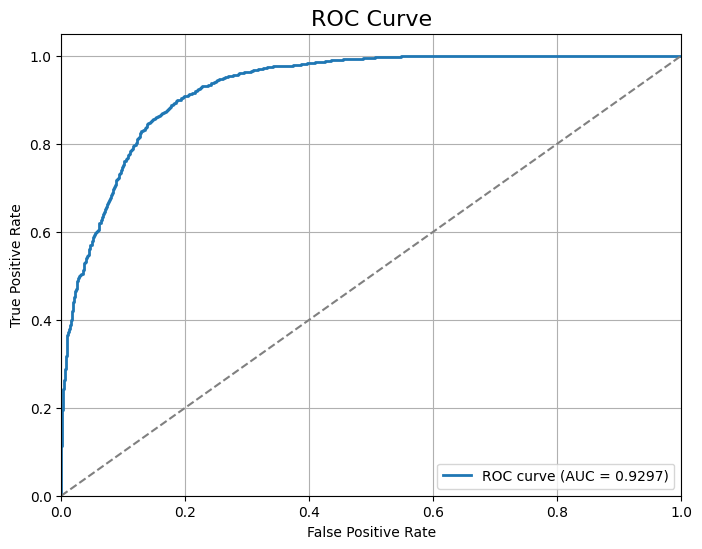

In [18]:
# Generate probabilities for the test set, .ravel() flattens the output to a 1D array, as required by roc_curve
y_scores = best_model.predict(X_test_scaled).ravel()

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds for the ROC curve and then the roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_value = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_value:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/roc_mlp_64.png", dpi=300)
plt.show()

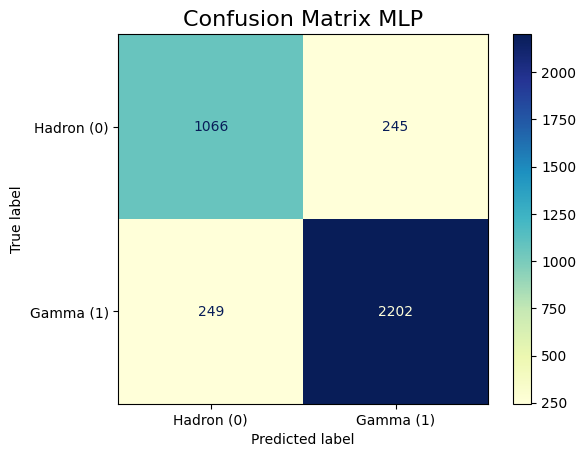

In [ ]:
# Convert predicted probabilities into binary class predictions
y_pred_binary = (y_scores > 0.5).astype(int)

#Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hadron (0)", "Gamma (1)"])

disp.plot(cmap='YlGnBu')
plt.title("Confusion Matrix MLP", fontsize=16)

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_mlp_64.png", dpi=300)
plt.show()

In [ ]:
# Get predicted probabilities and ROC curve
y_scores = best_model.predict(X_test_scaled).flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Find indices where the false positive rate (FPR) is below 5%
low_fpr_idx = np.where(fpr < 0.05)[0]

# Select the threshold with the highest TPR
best_idx = low_fpr_idx[-1]
threshold_01 = thresholds[best_idx]
print(f"\nThreshold selected (FPR < 0.05): {threshold_01:.4f}")

# Generate predictions using the selected threshold
y_pred_custom = (y_scores >= threshold_01).astype(int)

# Evaluate precision, recall, and confusion matrix
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
cm = confusion_matrix(y_test, y_pred_custom)

print(f"Precision: {precision:.4f}")
print(f"Recall (TPR): {recall:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Threshold selected (FPR < 0.05): 0.8615
Precision: 0.9561
Recall (TPR): 0.5769


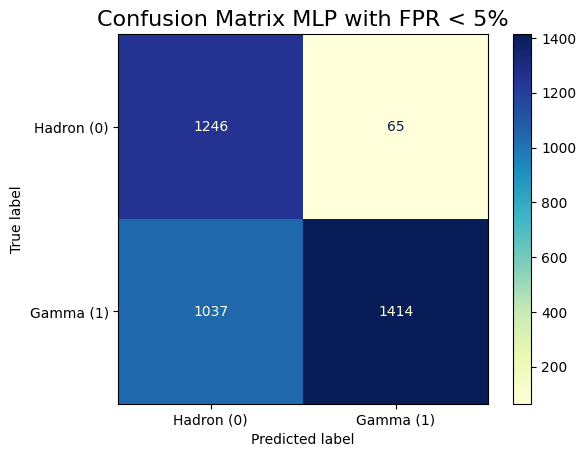

In [ ]:
# Confusion Matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hadron (0)", "Gamma (1)"])

disp.plot(cmap='YlGnBu')
plt.title(f"Confusion Matrix MLP with FPR < 5%", fontsize=16)

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_mlp_64_thresh_5.png", dpi=300)
plt.show()

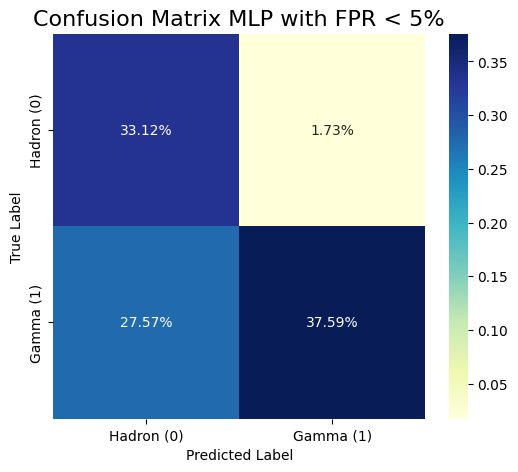

In [ ]:
# Confusion matrix with percentage
cm_normalized = cm / np.sum(cm)
labels = ["Hadron (0)", "Gamma (1)"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title(f"Confusion Matrix MLP with FPR < 5%", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_mlp_64_thresh_perc_5.png", dpi=300)
plt.show()

In [ ]:
# Get predicted probabilities and ROC curve
y_scores = best_model.predict(X_test_scaled).flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Find indices where the false positive rate (FPR) is below 10%
low_fpr_idx = np.where(fpr < 0.1)[0]

# Select the threshold with the highest TPR
best_idx = low_fpr_idx[-1]
threshold_01 = thresholds[best_idx]
print(f"\nThreshold selected (FPR < 0.10): {threshold_01:.4f}")

# Generate predictions using the selected threshold
y_pred_custom = (y_scores >= threshold_01).astype(int)

# Evaluate precision, recall, and confusion matrix
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
cm = confusion_matrix(y_test, y_pred_custom)

print(f"Precision: {precision:.4f}")
print(f"Recall (TPR): {recall:.4f}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Threshold selected (FPR < 0.10): 0.7306
Precision: 0.9336
Recall (TPR): 0.7515


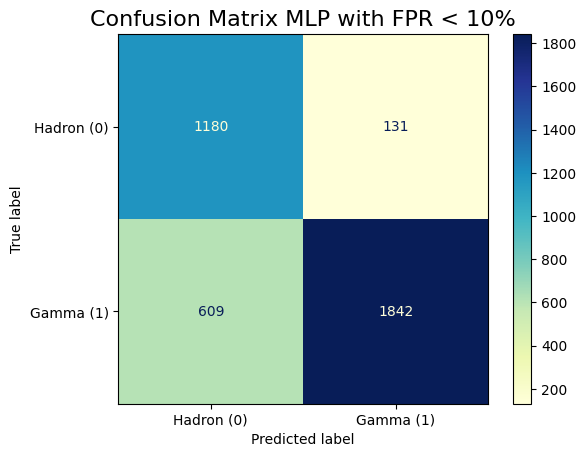

In [ ]:
# Confusion Matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hadron (0)", "Gamma (1)"])

disp.plot(cmap='YlGnBu')
plt.title(f"Confusion Matrix MLP with FPR < 10%", fontsize=16)

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_mlp_64_thresh_10.png", dpi=300)
plt.show()


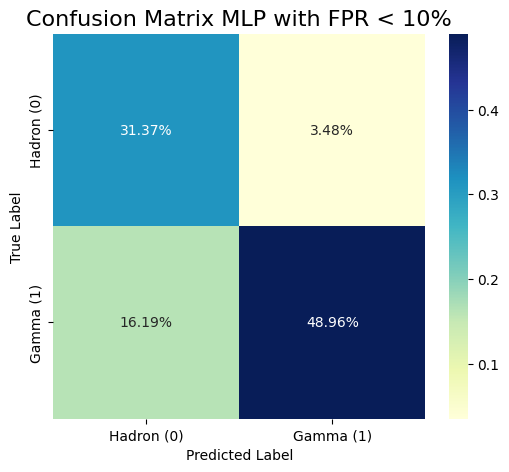

In [ ]:
# Confusion matrix with percentage
cm_normalized = cm / np.sum(cm)
labels = ["Hadron (0)", "Gamma (1)"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title(f"Confusion Matrix MLP with FPR < 10%", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#plt.savefig("/content/drive/MyDrive/MAGIC ML/immagini/confusion_matrix_mlp_64_thresh_perc_10.png", dpi=300)
plt.show()